In [19]:
import json
import copy
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras_tuner
from dataclasses import dataclass
from typing import List
from keras import layers, ops
from keras.utils import timeseries_dataset_from_array
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
from scipy.interpolate import griddata
%matplotlib inline

from processing import Stationarizer, Normalizer
from analysis import get_trials, get_RMSEs, make_histogram, plot_lrs, get_trials_df
from plotting import visualize_loss, show_plot
from model_builder import build_model, build_spec_model, get_tuner

In [2]:
trials = get_trials(110, "stock_predictor_2024-08-04 12:16:06.946981")
trials = get_RMSEs(trials)

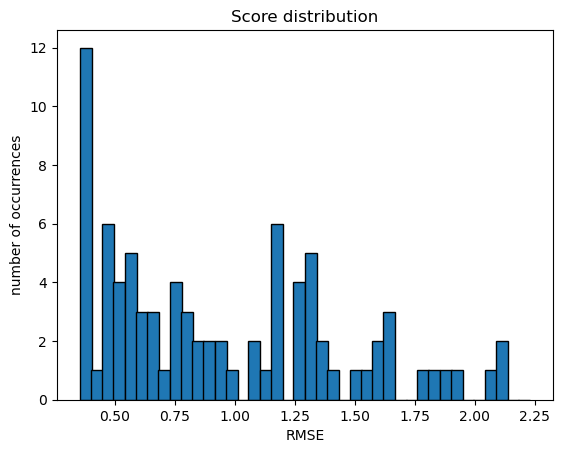

In [3]:
counts = make_histogram(trials, num_bins=40, width=0.05)

In [113]:
df = get_trials_df(trials)
df[:15]

,selu,activation,dropout_0,recurrent_dropout_0,dropout_1,recurrent_dropout_1,kernel_initializer_2,lr,trial id,rmse,mse,best step,total dropout
0,False,gelu,0.414469,0.148517,0.467546,0.058174,glorot_normal,0.000172,057,0.142405,0.020279,40,0.882015
1,False,silu,0.348969,0.187913,0.337712,0.078537,he_normal,0.000272,005,0.155311,0.024121,37,0.686681
2,False,silu,0.451860,0.114075,0.420675,0.017616,he_normal,0.003325,091,0.234644,0.055058,5,0.872535
3,False,gelu,0.474401,0.024148,0.263135,0.060509,he_normal,0.000197,074,0.267142,0.071365,47,0.737535
4,False,silu,0.462255,0.142668,0.480887,0.064180,glorot_uniform,0.000996,003,0.277319,0.076906,17,0.943142
5,False,gelu,0.211918,0.130799,0.289255,0.062778,he_normal,0.000478,022,0.280488,0.078673,35,0.501173
6,True,relu,0.433687,0.073192,0.443289,0.085482,glorot_normal,0.000686,081,0.290452,0.084362,41,0.876976
7,False,silu,0.256804,0.028902,0.385876,0.179166,he_normal,0.000191,069,0.292021,0.085276,49,0.642681
8,False,gelu,0.456840,0.096231,0.380015,0.192925,glorot_normal,0.000157,011,0.323011,0.104336,49,0.836855
9,True,silu,0.202458,0.156792,0.304052,0.079496,he_normal,0.002345,019,0.347715,0.120906,46,0.506510


In [ ]:
convergent = df[df["best step"] >= 40]
divergent = df[df["best step"] < 40]

Text(0, 0.5, 'LSTM layer 2 dropout')

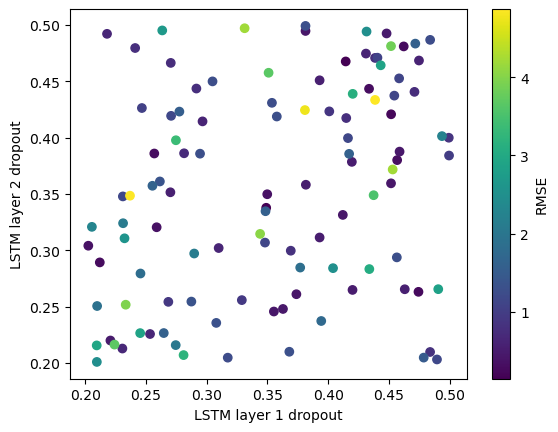

In [43]:
plt.scatter(df.loc[:, "dropout_0"], df.loc[:, "dropout_1"], c=df.loc[:, "rmse"])
plt.colorbar(label="RMSE")
plt.xlabel("LSTM layer 1 dropout")
plt.ylabel("LSTM layer 2 dropout")

Text(0.5, 1.0, 'Model RMSE vs. dropout rates')

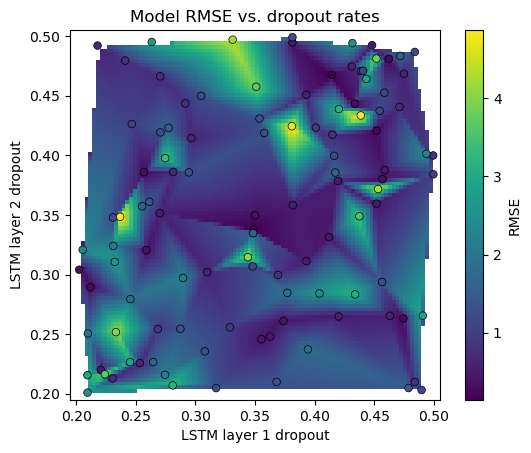

In [112]:
x = df.loc[:, "dropout_0"].to_numpy()
y = df.loc[:, "dropout_1"].to_numpy()
min_coord = 0.195 #min((min(x), min(y)))
max_coord = 0.505#max((max(x), max(y)))
grid_x, grid_y = np.mgrid[min_coord:max_coord:100j, min_coord:max_coord:100j]
points = list(zip(x, y))
vals = df.loc[:, "rmse"]
grid_z = griddata(points, vals, (grid_x, grid_y), method="linear")
plt.imshow(grid_z.T, extent=(min_coord, max_coord, min_coord, max_coord), origin="lower")
plt.scatter(df.loc[:, "dropout_0"], df.loc[:, "dropout_1"], s=30, c=df.loc[:, "rmse"], marker="o", edgecolor="black", linewidth=0.5)
plt.xlabel("LSTM layer 1 dropout")
plt.ylabel("LSTM layer 2 dropout")
plt.colorbar(label="RMSE")
plt.title("Model RMSE vs. dropout rates")

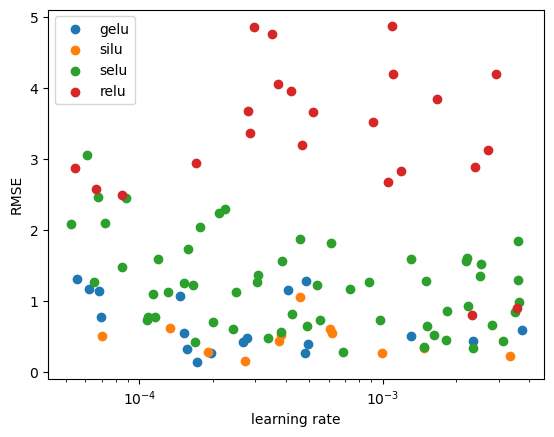

In [109]:
df.loc[df["selu"], "activation"] = "selu"
df.loc[df["selu"], "activation"] = "selu"

#plt.scatter(df["lr"], df["rmse"])
df[df["selu"]]
acts = df["activation"].unique()
for act in acts:
    plt.scatter(df.loc[df["activation"] == act, "lr"], df.loc[df["activation"] == act, "rmse"], label=act)
plt.legend()
plt.xlabel("learning rate")
plt.ylabel("RMSE")
plt.xscale("log")

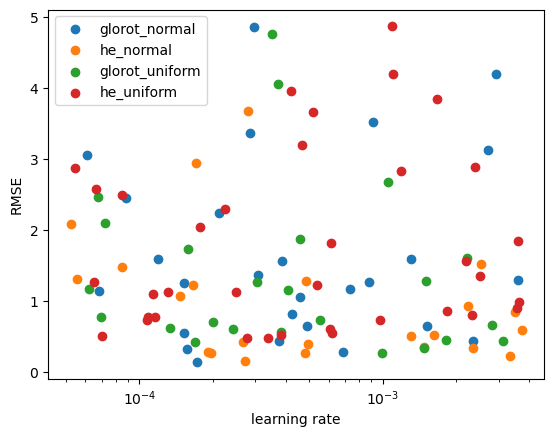

In [118]:
inits = df["kernel_initializer_2"].unique()
for init in inits:
    plt.scatter(df.loc[df["kernel_initializer_2"] == init, "lr"], df.loc[df["kernel_initializer_2"] == init, "rmse"], label=init)
plt.legend()
plt.xlabel("learning rate")
plt.ylabel("RMSE")
plt.xscale("log")

Text(0.5, 1.0, 'Model RMSE vs. recurrent dropout rates')

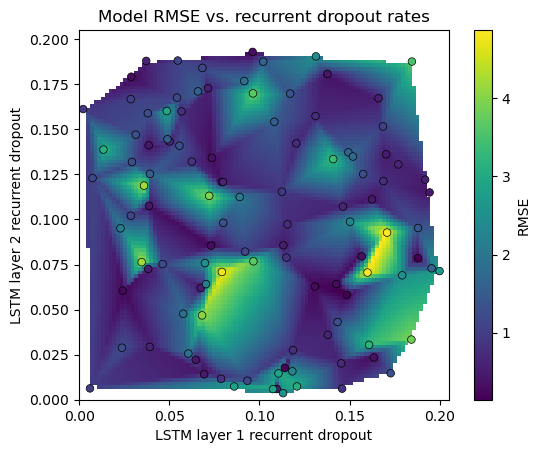

In [125]:
x = df.loc[:, "recurrent_dropout_0"].to_numpy()
y = df.loc[:, "recurrent_dropout_1"].to_numpy()
min_coord = 0 #min((min(x), min(y)))
max_coord = 0.205#max((max(x), max(y)))
grid_x, grid_y = np.mgrid[min_coord:max_coord:100j, min_coord:max_coord:100j]
points = list(zip(x, y))
vals = df.loc[:, "rmse"]
grid_z = griddata(points, vals, (grid_x, grid_y), method="linear")
plt.imshow(grid_z.T, extent=(min_coord, max_coord, min_coord, max_coord), origin="lower")
plt.scatter(df.loc[:, "recurrent_dropout_0"], df.loc[:, "recurrent_dropout_1"], s=30, c=df.loc[:, "rmse"], marker="o", edgecolor="black", linewidth=0.5)
plt.xlabel("LSTM layer 1 recurrent dropout")
plt.ylabel("LSTM layer 2 recurrent dropout")
plt.colorbar(label="RMSE")
plt.title("Model RMSE vs. recurrent dropout rates")